# Análise de dados

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn import tree
from sklearn.model_selection import RandomizedSearchCV

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
     for filename in filenames:
            print(os.path.join(dirname, filename))

In [3]:
train_df = pd.read_csv('../input/titanic/train.csv')
train_df.head()

FileNotFoundError: [Errno 2] No such file or directory: '../input/titanic/train.csv'

In [5]:
test_df = pd.read_csv('../input/titanic/test.csv')
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [6]:
print(train_df.shape)
print('-'*20)
print(test_df.shape)

(891, 12)
--------------------
(418, 11)


In [7]:
train_df.info()
print('-'*60)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  --

In [8]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


## Passageiros duplicados

In [9]:
train_df['PassengerId'].is_unique

True

In [10]:
# Ninguém tem nenhum passageiro duplicado repetido
train_df['Name'].value_counts().sort_values(ascending=True)

Braund, Mr. Owen Harris                         1
Andersson, Mr. Anders Johan                     1
Heikkinen, Miss. Laina                          1
Futrelle, Mrs. Jacques Heath (Lily May Peel)    1
Allen, Mr. William Henry                        1
                                               ..
Montvila, Rev. Juozas                           1
Graham, Miss. Margaret Edith                    1
Johnston, Miss. Catherine Helen "Carrie"        1
Laleff, Mr. Kristo                              1
Dooley, Mr. Patrick                             1
Name: Name, Length: 891, dtype: int64

## Criando colunas descritivas

In [11]:
colors = {'Survived':'steelblue',
          'Not survived':'firebrick'
         }

survived_or_not = {
    0: 'Not survived',
    1: 'Survived'
}
train_df['survived_or_not'] = train_df['Survived'].map(survived_or_not)


classes = {
    1: 'first class',
    2: 'second class',
    3: 'third class'
}
train_df['economic_classes'] = train_df['Pclass'].map(classes)
test_df['economic_classes'] = test_df['Pclass'].map(classes)


embarked = {
    'C': 'Cherbourg',
    'Q': 'Queenstown',
    'S': 'Southampton'
}
train_df['port_of_embarkation'] = train_df['Embarked'].map(embarked) 
test_df['port_of_embarkation'] = test_df['Embarked'].map(embarked) 

sex_int = {
    'Male': 1,
    'Female': 0
}


train_df['have_family'] = np.where((train_df.Parch >= 1) | (train_df.SibSp >= 1), 'have family members', 'not have family members')
train_df['sex_int'] = np.where((train_df.Sex == 'male'), 1, 0)

test_df['have_family'] = np.where((test_df.Parch >= 1) | (test_df.SibSp >= 1), 'have family members', 'not have family members')
test_df['sex_int'] = np.where((test_df.Sex == 'male'), 1, 0)


# 1. Exploração de dados

## 1.1 Distribuição dos passageiros

Olhando para a distribuição simples dos passageiros, de colunas que julguei serem as principais, podemos ter uma ideia de quem são eles. Olhando para as colunas de classe econômica, gênero, se tinha familiar ou não (esse gráfico olha para as duas colunas que apontam parentesco no navio. Caso as colunas Parch ou SibSp fossem maiores ou iguais a 1 então o passageiro é classificado como 'have family member'), qual o porto de embarque e idade. A partir dessa análise pudemos depreender que o perfil da maioria dos passageiros era:
**Homens jovens, entre 18 e 25 anos, sem familiares, viajentes da terceira classe e que embarcaram em Southampthon.**
Agora daremos uma olhada mais a fundo nesses passageiros. Vamos investigar isoladamente cada uma dessas classes afim de compreender mais sobre os viajantes.

In [12]:
colors = {'Survived':'steelblue',
      'Not survived':'firebrick'
     }


fig = make_subplots(
        rows=3, 
        cols=2,
    subplot_titles=(
        'Classe econômica', 'Gênero', 
        'Porto de embarque', 'Idade',
        'Tinha familiares ou não'
    )
)



fig.add_trace(
    go.Histogram(x=train_df['economic_classes'], histnorm='percent', marker=dict(color=colors['Survived'])),
    row=1,
    col=1,


)

fig.add_trace(
    go.Histogram(x=train_df['Sex'], histnorm='percent', marker=dict(color=colors['Survived'])),
    row=1,
    col=2
)


fig.add_trace(
        go.Histogram(x=train_df['port_of_embarkation'], histnorm='percent', marker=dict(color=colors['Survived'])),
    row=2,
    col=1
)

fig.add_trace(
        go.Histogram(x=train_df['Age'], histnorm='percent', marker=dict(color=colors['Survived'])),
    row=2,
    col=2
)

fig.add_trace(
        go.Histogram(x=train_df.have_family, histnorm='percent', marker=dict(color=colors['Survived'])),
    row=3,
    col=1
)


fig.update_layout(showlegend=False, height=1000, width=1200, coloraxis=dict(colorscale='Bluered_r'))

#     fig.write_image("images/fig1.png")
fig.show()

[(0.0, 100.0), Text(0.5, 0, '')]

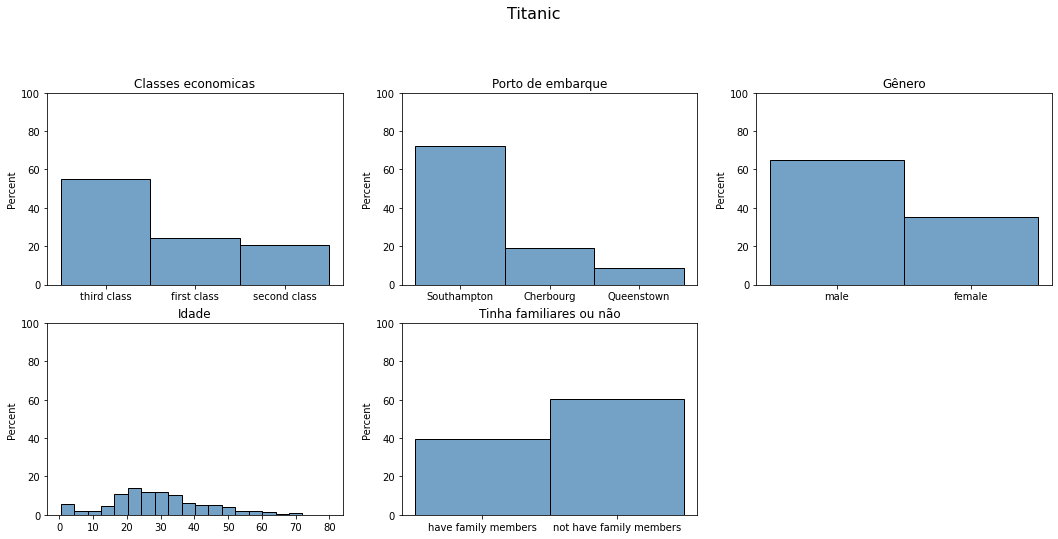

In [13]:
plt.figure(figsize=(18,12))
plt.suptitle('Titanic', size=16)
plt.tight_layout(pad=1.15, h_pad=1.5, w_pad=1.15, rect=None)

plt.subplot(331).set_title('Classes economicas')
sns.histplot(train_df.economic_classes, stat='percent', color='steelblue').set(ylim=(0, 100), xlabel='')

plt.subplot(332).set_title('Porto de embarque')
sns.histplot(train_df.port_of_embarkation, stat='percent', color='steelblue').set(ylim=(0, 100), xlabel='')


plt.subplot(333).set_title("Gênero")
sns.histplot(train_df.Sex, stat='percent', color='steelblue').set(ylim=(0, 100), xlabel='')

plt.subplot(334).set_title("Idade")
sns.histplot(train_df.Age, stat='percent', color='steelblue').set(ylim=(0, 100), xlabel='')

plt.subplot(335).set_title("Tinha familiares ou não")
sns.histplot(train_df.have_family, stat='percent', color='steelblue').set(ylim=(0, 100), xlabel='')

In [14]:
print(train_df.columns)
features = [
    'Sex', 
    'Age', 
    'survived_or_not',
    'economic_classes', 
    'port_of_embarkation', 
    'have_family']
list_features = list(enumerate(features))
print(list_features)

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'survived_or_not',
       'economic_classes', 'port_of_embarkation', 'have_family', 'sex_int'],
      dtype='object')
[(0, 'Sex'), (1, 'Age'), (2, 'survived_or_not'), (3, 'economic_classes'), (4, 'port_of_embarkation'), (5, 'have_family')]


### 1.2 Sobrevivência dos passageiros

Olharemos, agora, para o nosso objetivo. Analisaremos sobre quem sobreviveu ao trágico acidente e quais das features pode ter uma correlação direta com a sobrevivência ou não dos passageiros. A partir da nossa análise podemos depreender que:
1. A maioria dos passageiros viajaram de terceira classe e, também, foi onde o maior percentual de passageiros morreram no naufrágio. Possivelmente por estarem alojados na área frontal do návio, onde ocorreu o choque com o iceberg. Dando menos tempo para que eles pudessem escapar com vida.
2. A maioria dos passageiros era do sexo masculino, mas proporcionalmente quem mais sobreviveu foram as pessoas do sexo feminino. Mais de 75% das mulheres sobreviveram enquanto 80% do homens não escaparam com vivda. Uma possível explicação é o padrão de salvamento das pessoas. A equipe do návio desembarcava, para os botes salva-vidas, primemiro as mulheres e as crianças
3. É o que podemos ver na distribuição por idade. Enquanto a maior parte dos passageiros eram jovens, de 18 a 30 anos, a faixa de idade que mais sobreviveu foram de crianças de 0 a 11 anos. Únicas faixas de idade que ficam acima de 50% de sobreviventes.

In [15]:
def data_frame(col):
    df = (
        train_df
        .groupby(col)['survived_or_not']
        .value_counts(normalize=True)
        .rename('percent')
        .mul(100)
        .reset_index()
        .round(2)
    )
       
    return df

In [16]:
df = data_frame('economic_classes')
df2 = data_frame('Sex')
df3 = data_frame('port_of_embarkation')
df4 = data_frame('have_family')

# assign colors to type using a dictionary
colors = {'Survived':'steelblue',
          'Not survived':'firebrick'
         }


# plotly figure
fig=make_subplots(
    rows=3,
    cols=2,
    shared_yaxes=True,
    subplot_titles=('% Sobreviventes classe economica', 
                    '% Sobreviventes por gênero', 
                    '% Sobreviventes por porto de embarque', 
                    '% Sobreviventes com familiares ou não')
)

for t in df['survived_or_not'].unique():
    dfp = df[df['survived_or_not']==t]
    fig.add_traces(
        go.Bar(
            x=dfp['economic_classes'], 
            y = dfp['percent'], 
            name=t,
            marker_color=colors[t],
            text=dfp['percent']
        ),
        1,1
    )
    
for i in df2['survived_or_not'].unique():
    dfp = df2[df2['survived_or_not']==i]
    fig.add_traces(
        go.Bar(
            x=dfp['Sex'], 
            y = dfp['percent'],
            marker_color=colors[i],
            showlegend=False,
            text=dfp['percent']
            ),
        1,2
    )
    
for i in df3['survived_or_not'].unique():
    dfp = df3[df3['survived_or_not']==i]
    fig.add_traces(
        go.Bar(
            x=dfp['port_of_embarkation'], 
            y = dfp['percent'],
            marker_color=colors[i],
            showlegend=False,
            text=dfp['percent']
            ),
        2,1
    )

for i in df4['survived_or_not'].unique():
    dfp = df4[df4['survived_or_not']==i]
    fig.add_traces(
        go.Bar(
            x=dfp['have_family'], 
            y = dfp['percent'],
            marker_color=colors[i],
            showlegend=False,
            text=dfp['percent']
            ),
        2,2
    )

fig.update_layout(showlegend=True, height=1100, width=1400)
fig.show()

In [17]:
fig = (
px.histogram(
    train_df, 
    x="Age", 
    color="survived_or_not", 
    barmode="overlay",
    #histnorm='percent',
    color_discrete_map = colors
    )
)

fig.update_layout(
    title_text = 'Sobreviventes por idade'
)

# fig.update_yaxes(range=[0,10])

fig.show()

<AxesSubplot:>

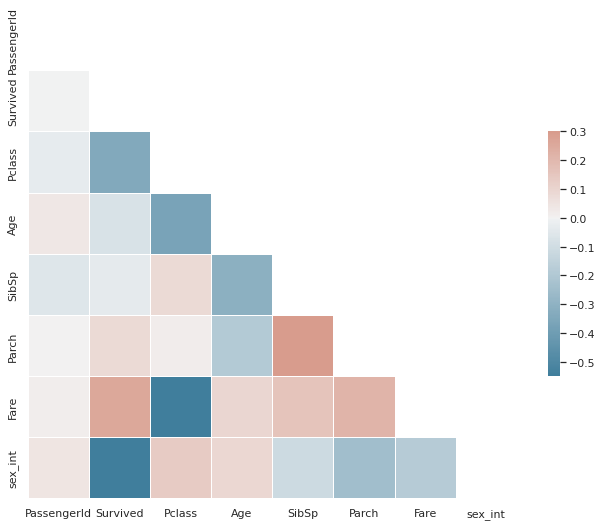

In [18]:
sns.set_theme(style="white")

# Generate a large random dataset


# Compute the correlation matrix
corr = train_df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

## Achei uma interessante correlação entre preço da passagem e se sobreviveu ou não

## 1.1.1 Idades nulas
Em todo o dataset de treino temos 177 pessoas com idades nulas.
A porcentagem de homens sem idade é maior do que a porcentagem de homens no geral, mas é uma diferença pequena.

Comparado com a proporção de passageiros das classes economicas muda a distribuição. Tem mais passageiros da primeira classe sem idade, sendo que tem mais passageiros, no geral, da segunda classe

A diferença também é pequena para os passageiros que sobreviveram ou não.

A proporção de passageiros que embarcaram nos portos muda. No geral mais de 70% embarcaram em Southampton e, dos que não tem idade declarada, são apenas 50%. Em Cherbourg embarcaram mais pessoas, mas ele aparece um pouco abaixo nessa amostragem de pessoas sem idade.

In [19]:
# 158 pessoas com idade e cabine nulas
null_df_age = train_df[train_df['Age'].isnull()].copy()
null_df_age.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 177 entries, 5 to 888
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   PassengerId          177 non-null    int64  
 1   Survived             177 non-null    int64  
 2   Pclass               177 non-null    int64  
 3   Name                 177 non-null    object 
 4   Sex                  177 non-null    object 
 5   Age                  0 non-null      float64
 6   SibSp                177 non-null    int64  
 7   Parch                177 non-null    int64  
 8   Ticket               177 non-null    object 
 9   Fare                 177 non-null    float64
 10  Cabin                19 non-null     object 
 11  Embarked             177 non-null    object 
 12  survived_or_not      177 non-null    object 
 13  economic_classes     177 non-null    object 
 14  port_of_embarkation  177 non-null    object 
 15  have_family          177 non-null    obj

In [20]:
fig = make_subplots(
        rows=3, 
        cols=2,
        subplot_titles=('Gêneros', 'Classes econômicas', 'Quantidade de sobreviventes', 'Porto em que embarcaram')
)



fig.add_trace(
    go.Histogram(x=null_df_age['Sex'], histnorm='percent', marker=dict(color=colors['Survived'])),
    row=1,
    col=1,
    
)

fig.add_trace(
    go.Histogram(x=null_df_age["economic_classes"], histnorm='percent', marker=dict(color=colors['Survived'])),
    row=1,
    col=2
)


fig.add_trace(
        go.Histogram(x=null_df_age['survived_or_not'], histnorm='percent', marker=dict(color=colors['Survived'])),
    row=2,
    col=1
)

fig.add_trace(
        go.Histogram(x=null_df_age['port_of_embarkation'], histnorm='percent', marker=dict(color=colors['Survived'])),
    row=2,
    col=2
)

fig.add_trace(
        go.Histogram(x=null_df_age['have_family'], histnorm='percent', marker=dict(color=colors['Survived'])),
    row=3,
    col=1
)

# fig.add_trace(
#         go.Histogram(x=null_df_age['Age'], histnorm='percent'),
#     row=3,
#     col=2
# )


fig.update_layout(showlegend=False, height=1000, width=1200, coloraxis=dict(colorscale='Bluered_r'))
fig.show()

## 1.1.2 Cabines nulas
687 pessoas estão com as cabines nulas.
Os passageiros sem informação das cabines seguem a mesma proporção, pelo menos muito parecida, dos passageiros com idade nula e do restante dos passageiros. Só que tem mais usuários das classes mais baixas

In [21]:
null_cabin = train_df[train_df['Cabin'].isnull()]
null_cabin.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 687 entries, 0 to 890
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   PassengerId          687 non-null    int64  
 1   Survived             687 non-null    int64  
 2   Pclass               687 non-null    int64  
 3   Name                 687 non-null    object 
 4   Sex                  687 non-null    object 
 5   Age                  529 non-null    float64
 6   SibSp                687 non-null    int64  
 7   Parch                687 non-null    int64  
 8   Ticket               687 non-null    object 
 9   Fare                 687 non-null    float64
 10  Cabin                0 non-null      object 
 11  Embarked             687 non-null    object 
 12  survived_or_not      687 non-null    object 
 13  economic_classes     687 non-null    object 
 14  port_of_embarkation  687 non-null    object 
 15  have_family          687 non-null    obj

In [22]:
fig = make_subplots(
        rows=3, 
        cols=2,
        subplot_titles=(
            'Gêneros', 'Classes econômicas', 
            'Quantidade de sobreviventes', 'Porto em que embarcaram',
            'Tem familiares ou não', 'Idade'
            
        )
)



fig.add_trace(
    go.Histogram(x=null_cabin['Sex'], histnorm='percent', marker=dict(color=colors['Survived'])),
    row=1,
    col=1,
    
)

fig.add_trace(
    go.Histogram(x=null_cabin["economic_classes"], histnorm='percent', marker=dict(color=colors['Survived'])),
    row=1,
    col=2
)


fig.add_trace(
        go.Histogram(x=null_cabin['survived_or_not'], histnorm='percent', marker=dict(color=colors['Survived'])),
    row=2,
    col=1
)

fig.add_trace(
        go.Histogram(x=null_cabin['port_of_embarkation'], histnorm='percent', marker=dict(color=colors['Survived'])),
    row=2,
    col=2
)

fig.add_trace(
        go.Histogram(x=null_cabin['have_family'], histnorm='percent', marker=dict(color=colors['Survived'])),
    row=3,
    col=1
)

fig.add_trace(
        go.Histogram(x=null_cabin['Age'], histnorm='percent', marker=dict(color=colors['Survived'])),
    row=3,
    col=2
)


fig.update_layout(showlegend=False, height=1000, width=1200, coloraxis=dict(colorscale='Bluered_r'))
fig.show()

# 1.1.3 Porto de embarque nulo


In [23]:
embarked_null = train_df[train_df['Embarked'].isnull()].copy()
embarked_null.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 61 to 829
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   PassengerId          2 non-null      int64  
 1   Survived             2 non-null      int64  
 2   Pclass               2 non-null      int64  
 3   Name                 2 non-null      object 
 4   Sex                  2 non-null      object 
 5   Age                  2 non-null      float64
 6   SibSp                2 non-null      int64  
 7   Parch                2 non-null      int64  
 8   Ticket               2 non-null      object 
 9   Fare                 2 non-null      float64
 10  Cabin                2 non-null      object 
 11  Embarked             0 non-null      object 
 12  survived_or_not      2 non-null      object 
 13  economic_classes     2 non-null      object 
 14  port_of_embarkation  0 non-null      object 
 15  have_family          2 non-null      obje

In [24]:
embarked_null

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,survived_or_not,economic_classes,port_of_embarkation,have_family,sex_int
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN,Survived,first class,NaN,not have family members,0
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN,Survived,first class,NaN,not have family members,0


# 2. Árvore de decisão

In [25]:
seed=10

In [26]:
mean_age = train_df['Age'].mean()
train_df['Age'].fillna(value=mean_age, inplace=True)

 
mean_fare = train_df['Fare'].mean()
train_df['Fare'].fillna(value=mean_fare, inplace=True)

train_df.shape


(891, 17)

In [27]:
mean_age = test_df['Age'].mean()
test_df['Age'].fillna(value=mean_age, inplace=True)
mean_fare = test_df['Fare'].mean()
test_df['Fare'].fillna(value=mean_fare, inplace=True)
test_df.shape

(418, 15)

In [28]:
columns_to_drop = [
    "Survived", 
    'Name', 
    'Sex', 
    'Ticket', 
    'PassengerId', 
    'Cabin', 
    'survived_or_not', 
    'economic_classes',
    'port_of_embarkation',
    'have_family',
    'Embarked'
    ]

X_train = train_df.drop(columns_to_drop, axis=1).copy()
Y_train = train_df["Survived"]
X_test  = test_df.drop([
    'Name', 
    'Sex', 
    'Ticket', 
    'PassengerId', 
    'Cabin',
    'economic_classes',
    'port_of_embarkation',
    'have_family',
    'Embarked'
    ], axis=1).copy()
X_train.shape, Y_train.shape, X_test.shape

((891, 6), (891,), (418, 6))

In [29]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Pclass   891 non-null    int64  
 1   Age      891 non-null    float64
 2   SibSp    891 non-null    int64  
 3   Parch    891 non-null    int64  
 4   Fare     891 non-null    float64
 5   sex_int  891 non-null    int64  
dtypes: float64(2), int64(4)
memory usage: 41.9 KB


In [30]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Pclass   418 non-null    int64  
 1   Age      418 non-null    float64
 2   SibSp    418 non-null    int64  
 3   Parch    418 non-null    int64  
 4   Fare     418 non-null    float64
 5   sex_int  418 non-null    int64  
dtypes: float64(2), int64(4)
memory usage: 19.7 KB


## Parâmetros default

In [31]:
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)

Y_pred = decision_tree.predict(X_test)
acc_decision_tree = round(decision_tree.score(X_train, Y_train) * 100, 2)
acc_decision_tree

#pontuação -> 0,74641
#posição -> 11.999

98.2

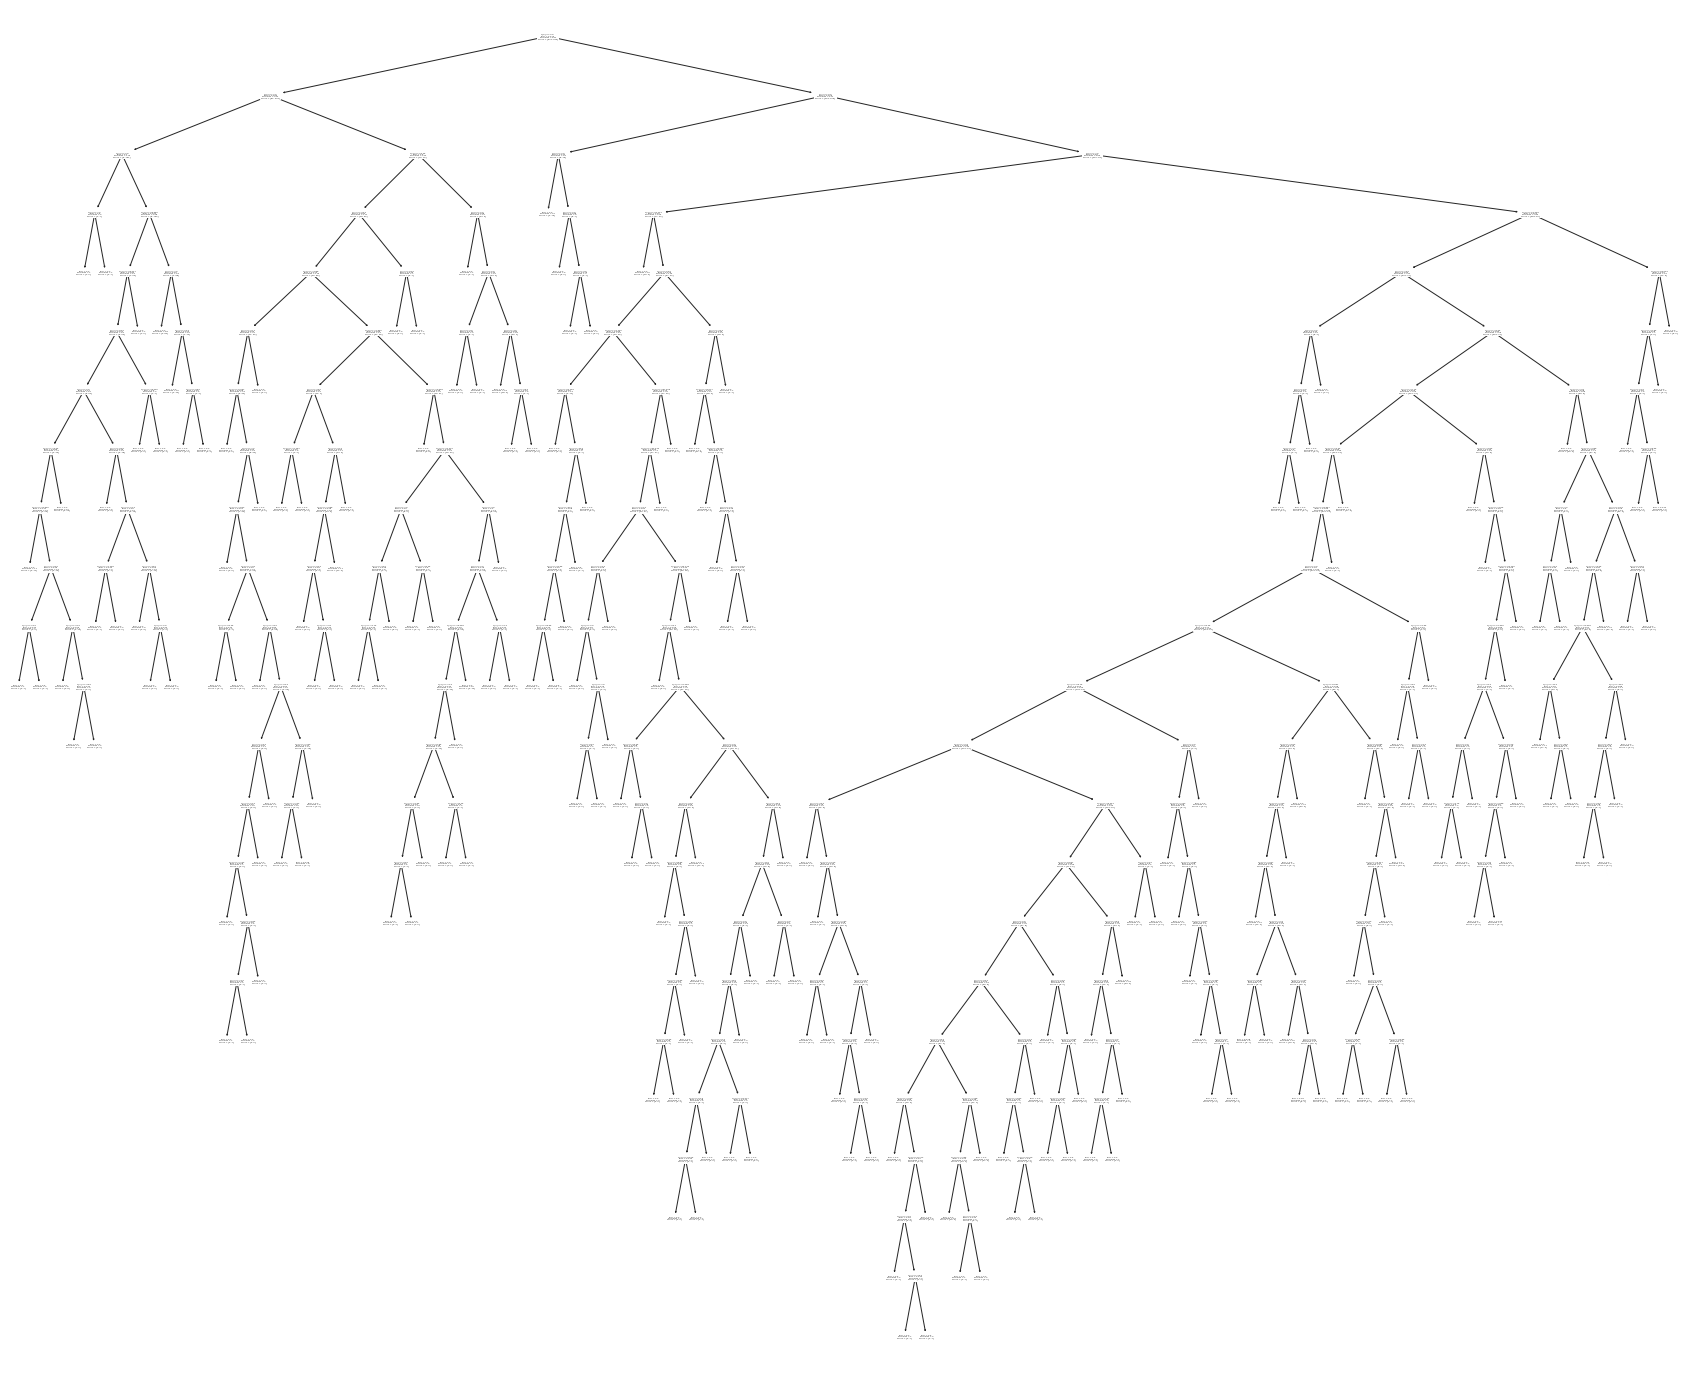

In [32]:
# criando o fig e o axes
fig, ax = plt.subplots(figsize=(30, 25))
#criando o plot
plot_tree(decision_tree,ax=ax)
#plotando o gráfico
plt.savefig('tree_decision.png')

## max_depth = 2
Entendendo àrvore de decisão

In [33]:
decision_tree = DecisionTreeClassifier(max_depth=2, random_state=seed)
decision_tree.fit(X_train, Y_train)

Y_pred = decision_tree.predict(X_test)
acc_decision_tree = round(decision_tree.score(X_train, Y_train) * 100, 2)
acc_decision_tree

#0,77033
#posição -> 8607

79.57

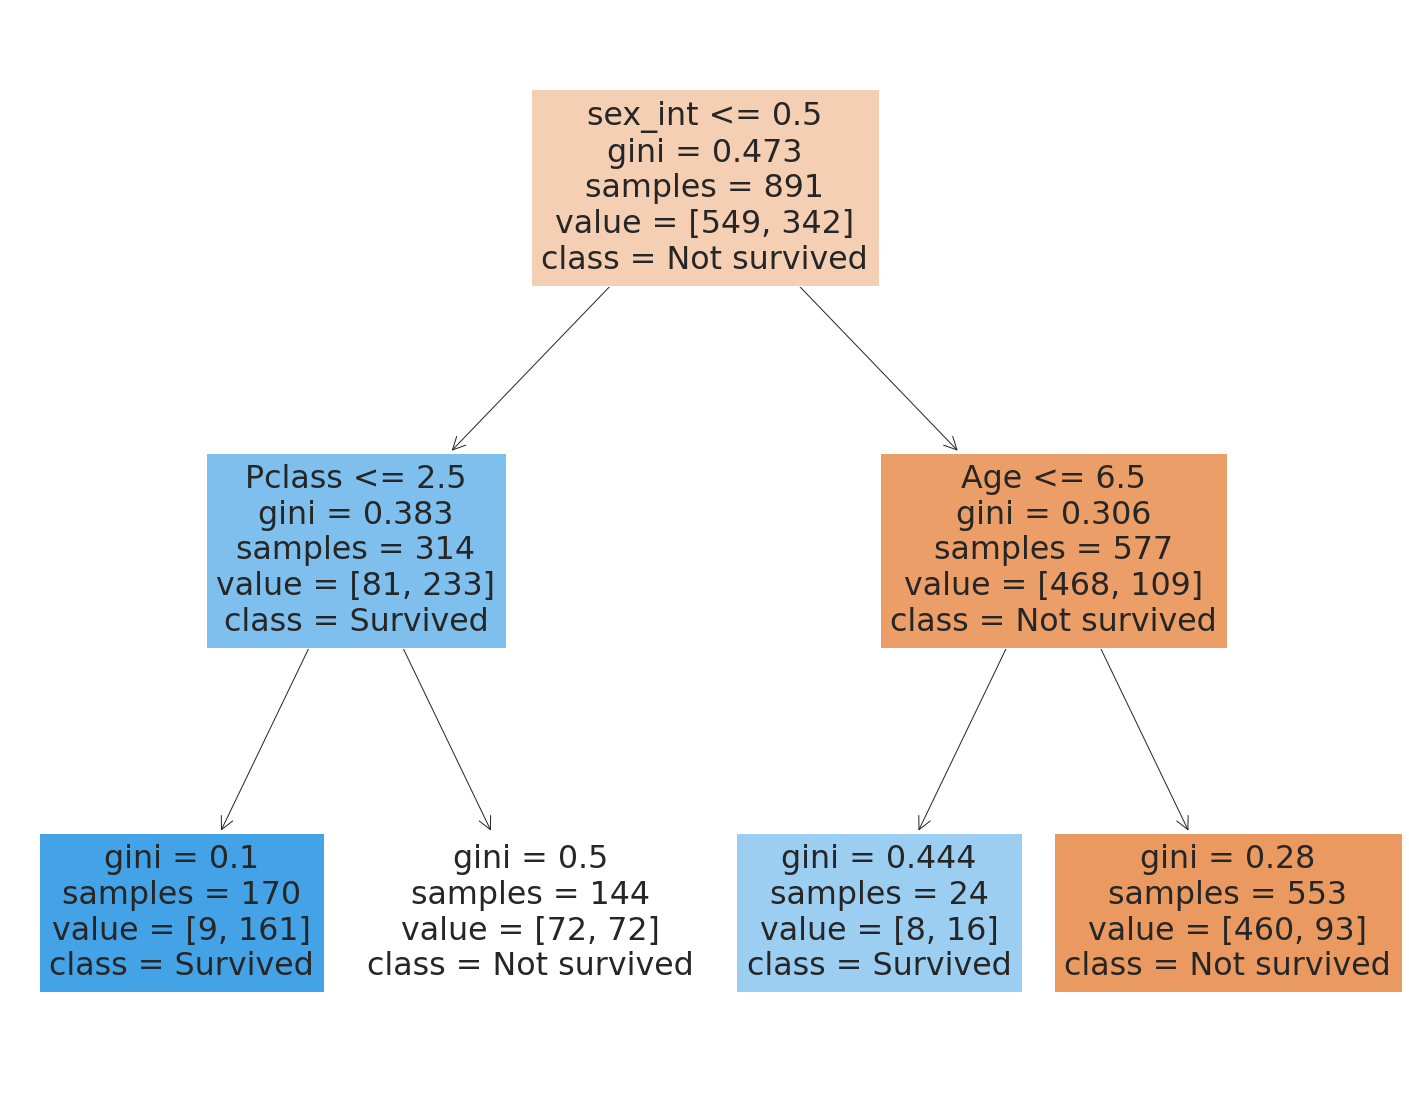

In [34]:
feature_names= X_train.columns
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(decision_tree, 
                   feature_names=X_train.columns,  
                   class_names=train_df.survived_or_not,
                   filled=True)
plt.savefig('treeplot.png')

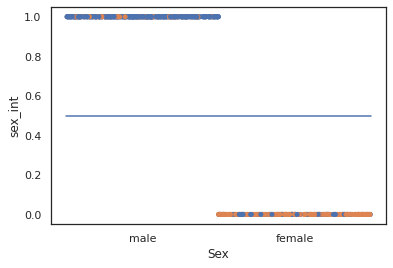

In [35]:
ax = sns.stripplot(x='Sex', y='sex_int', data=train_df, jitter=0.5, hue='Survived')
ax = sns.lineplot(x=[-0.5,1.5], y=[0.5, 0.5])
ax.legend_.remove()
plt.show()

In [36]:
#Feminino
df_f = train_df[train_df['sex_int'] <= 0.5].copy()
df_f['Survived'].value_counts()

1    233
0     81
Name: Survived, dtype: int64

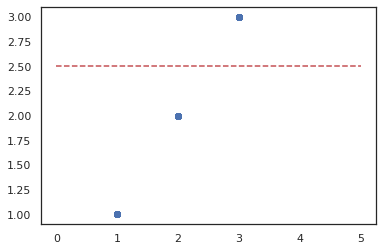

In [37]:
fig, ax = plt.subplots()

ax.scatter(y=df_f.Pclass,
           x=df_f.Pclass,
           
          )
ax.plot([0, 5], [2.5, 2.5], '--r')

In [38]:
df_f[df_f['Pclass'] <= 2.5]['Survived'].value_counts()

1    161
0      9
Name: Survived, dtype: int64

[Text(0, 0, '0'),
 Text(10, 0, '10'),
 Text(20, 0, '20'),
 Text(30, 0, '30'),
 Text(40, 0, '40'),
 Text(50, 0, '50'),
 Text(60, 0, '60'),
 Text(70, 0, '70'),
 Text(80, 0, '80')]

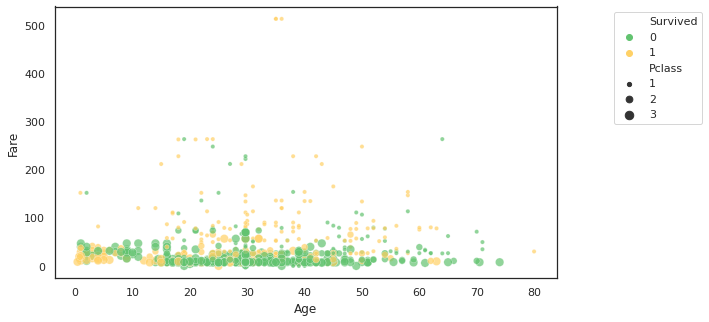

In [39]:
# Change default palette
sns.set_palette(['#62C370', '#FFD166', '#EF476F'])# Plot
plt.figure(figsize=(9, 5))
ax = sns.scatterplot(data=train_df, x='Age', y='Fare', 
                alpha=0.7, hue='Survived', size='Pclass')
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1))
ax.set_xticks([0,10,20,30,40,50,60,70,80])
ax.set_xticklabels([0,10,20,30,40,50,60,70,80])


## Outros parâmetros

83.61


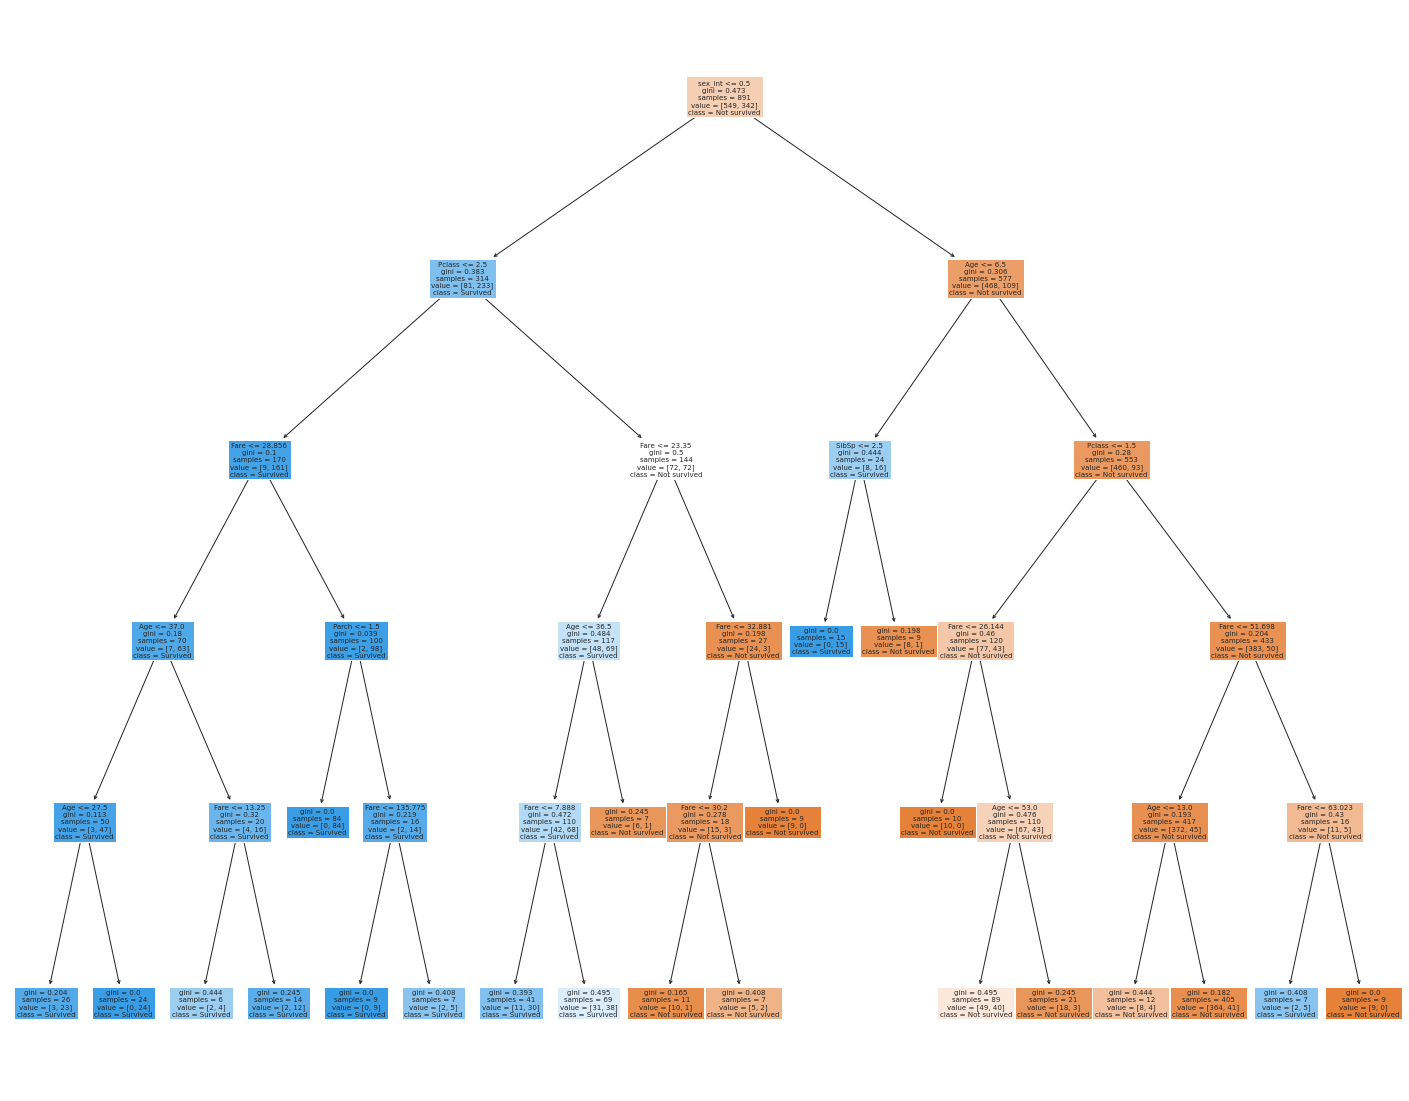

In [40]:
tree1 = DecisionTreeClassifier(
    criterion='gini',
    splitter='best',
    max_depth=5,
    min_samples_leaf=5,
    min_samples_split=5,
    
    random_state=seed)

tree1.fit(X_train, Y_train)
y_pred = tree1.predict(X_test)
accuracy1 = round(tree1.score(X_train, Y_train) * 100, 2)
print(accuracy1)


fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(tree1, 
                   feature_names=X_train.columns,  
                   class_names=train_df.survived_or_not,
                   filled=True);


submission = test_df[['PassengerId']].copy()
submission['Survived'] = Y_pred
submission.to_csv('submission1.csv', index=None)

#pontuação -> 0,77033

83.61


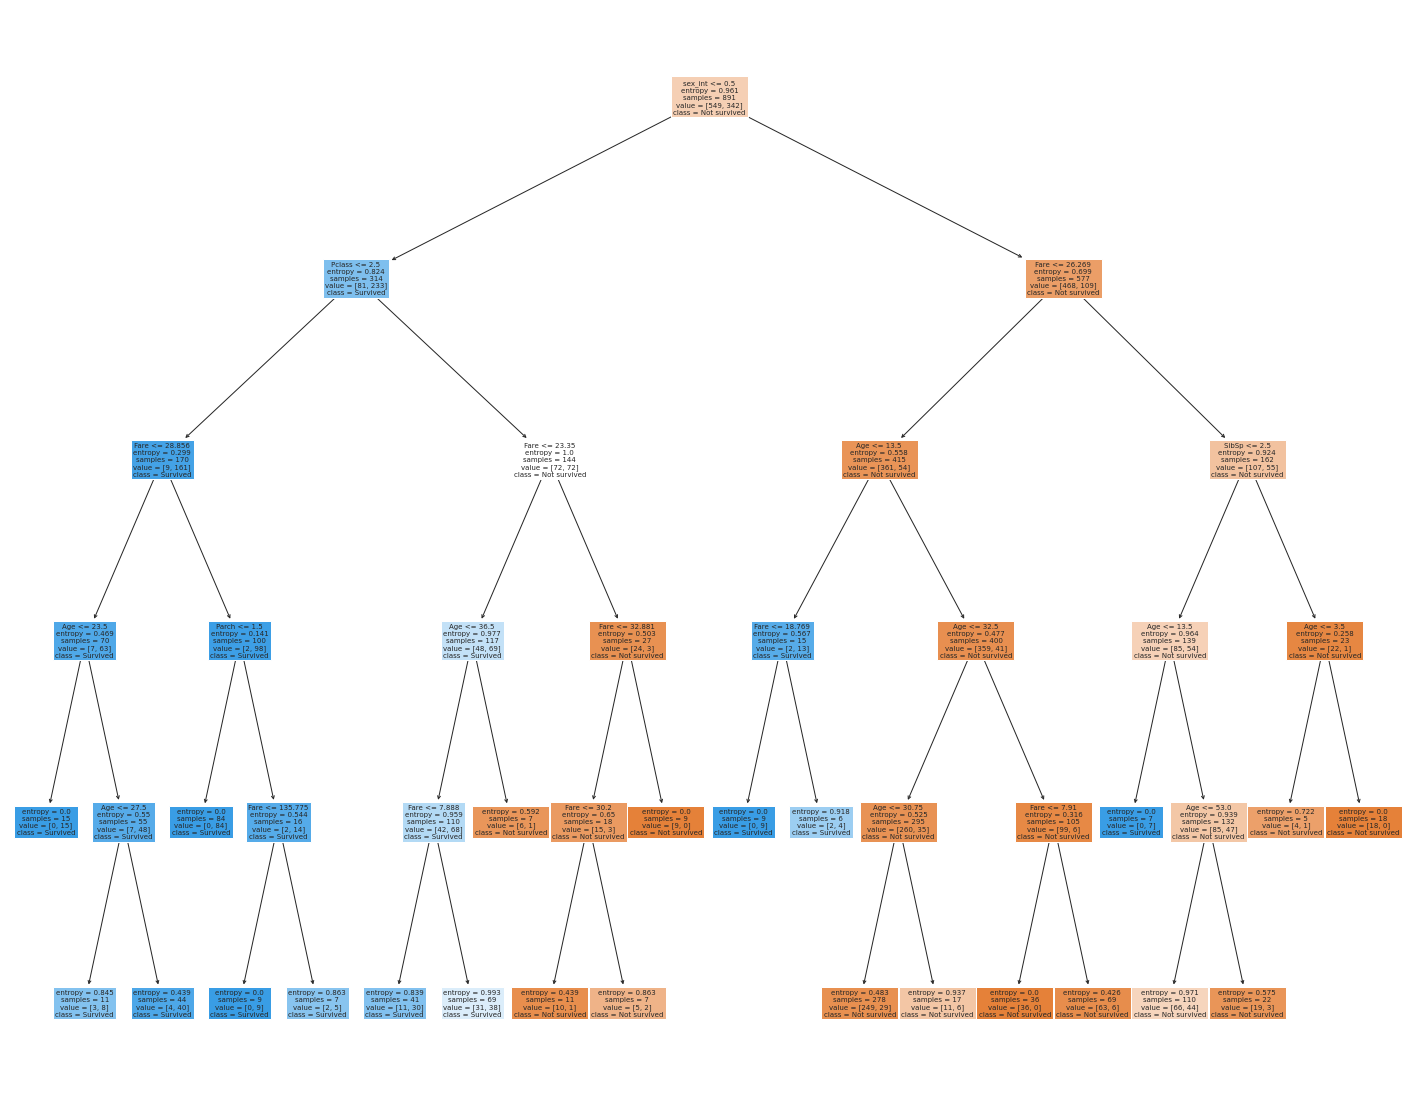

In [41]:
tree2 = DecisionTreeClassifier(
    criterion='entropy',
    min_samples_leaf=5,
    min_samples_split=5,
    max_depth=5,
    random_state=seed)

tree2.fit(X_train, Y_train)
y_pred = tree2.predict(X_test)
accuracy = round(tree2.score(X_train, Y_train) * 100, 2)
print(accuracy)

fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(tree2, 
                   feature_names=X_train.columns,  
                   class_names=train_df.survived_or_not,
                   filled=True)

In [42]:
train_df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'survived_or_not',
       'economic_classes', 'port_of_embarkation', 'have_family', 'sex_int'],
      dtype='object')

86.53


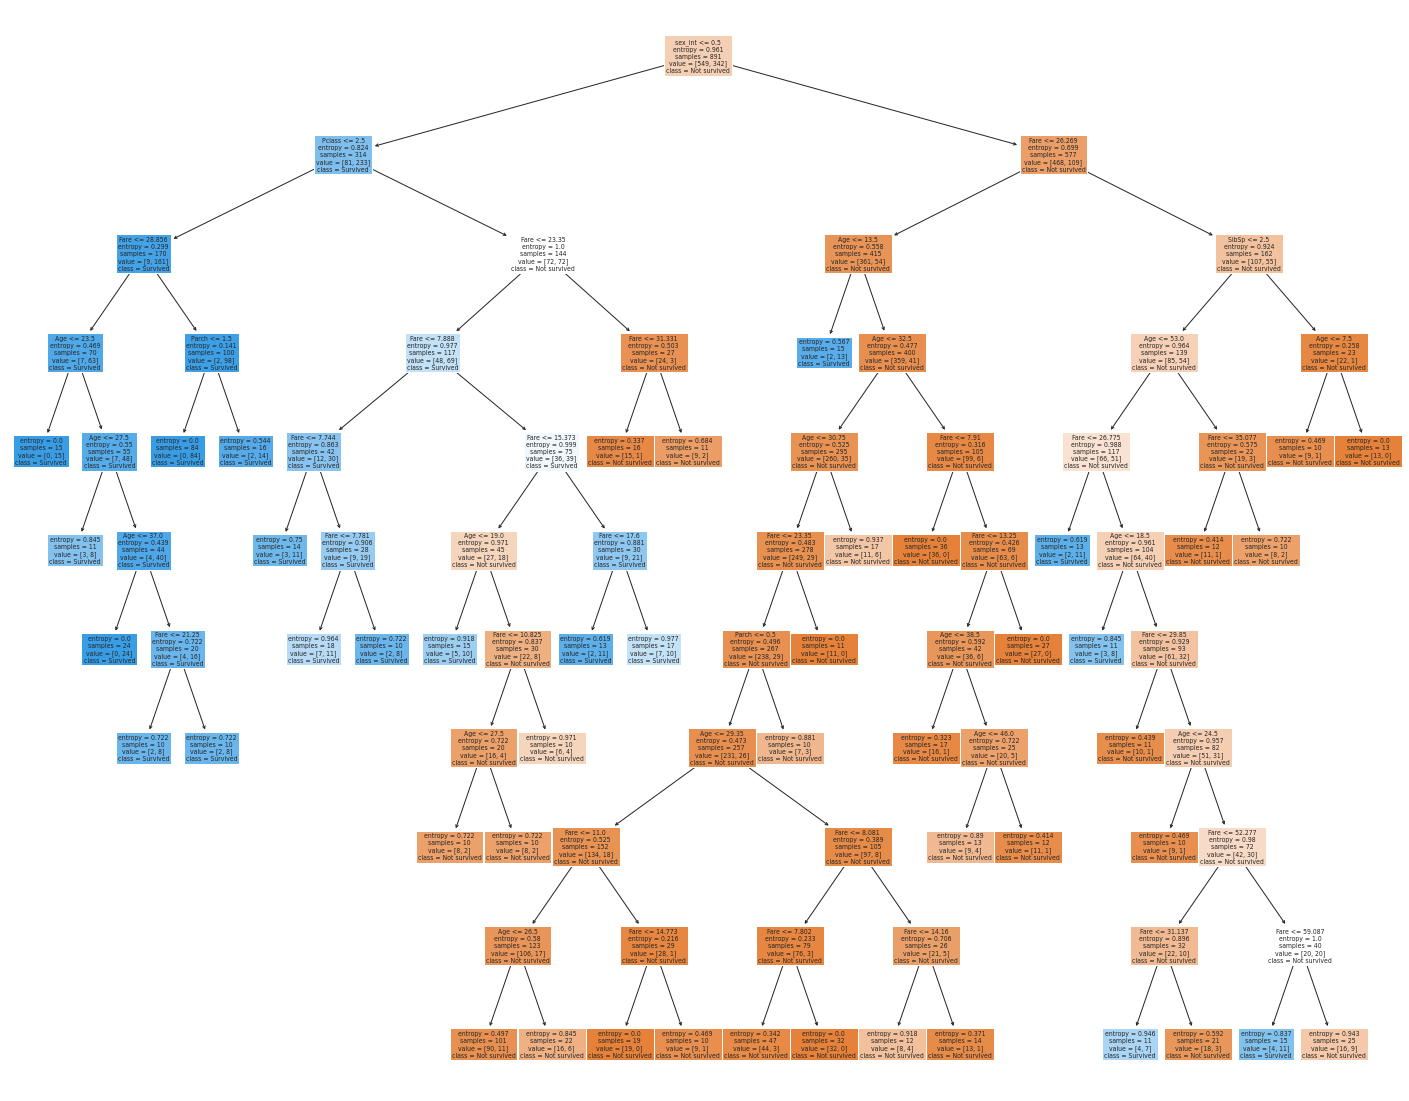

In [43]:
tree3 = DecisionTreeClassifier(
    criterion='entropy',
    min_samples_leaf=10,
    min_samples_split=10,
    max_depth=10,
    random_state=seed)

tree3.fit(X_train, Y_train)
y_pred = tree3.predict(X_test)
accuracy = round(tree3.score(X_train, Y_train) * 100, 2)
print(accuracy)

fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(tree3, 
                   feature_names=X_train.columns,  
                   class_names=train_df.survived_or_not,
                   filled=True)

## 3.1.1 Feature importance

In [44]:
#criando um dicionário com as variáveis
dic = {'score':decision_tree.feature_importances_,'features':X_train.columns}
dic

{'score': array([0.186582  , 0.06844432, 0.        , 0.        , 0.        ,
        0.74497368]),
 'features': Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'sex_int'], dtype='object')}

In [45]:
# A feature de sexo aparece como a mais importante de todas e as de família não tem importância nenhuma.
#Talvez trabalhar mais em cima dessas features? 
dic = {'score':decision_tree.feature_importances_,'features':X_train.columns}
#criando um dataframe com os dados
df = pd.DataFrame(dic).sort_values('score',ascending=False)
df

,score,features
5,0.744974,sex_int
0,0.186582,Pclass
1,0.068444,Age
2,0.000000,SibSp
3,0.000000,Parch
4,0.000000,Fare


In [46]:
df.reset_index()

,index,score,features
0,5,0.744974,sex_int
1,0,0.186582,Pclass
2,1,0.068444,Age
3,2,0.000000,SibSp
4,3,0.000000,Parch
5,4,0.000000,Fare


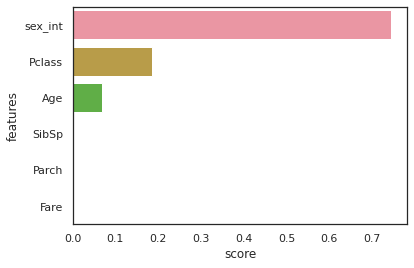

In [47]:
ax = sns.barplot(data=df, y="features", x='score')


## Tunning modelo

### Hyperparameter tuning

In [48]:
parameters = {
    'criterion' : ['entropy', 'gini'],
    'min_samples_leaf' : [3, 5, 6, 7, 8, 9, 10, 20],
    'min_samples_split' : [3, 5, 6, 7, 8, 9, 10, 20],
    'max_depth' : [3, 5, 6, 7, 8, 9, 10, 20]
}

In [49]:
parameters = {
    'criterion' : ('entropy', 'gini'),
    'min_samples_leaf' : (3, 5, 6, 7, 8, 9, 10, 20),
    'min_samples_split' : (3, 5, 6, 7, 8, 9, 10, 20),
    'max_depth' : (3, 5, 6, 7, 8, 9, 10, 20)
}

In [50]:
hyper_tree = RandomizedSearchCV(
    DecisionTreeClassifier(), 
    param_distributions = parameters,
    cv = 5,
    verbose=True,
)

hyper_tree.fit(X_train, Y_train)
# Y_pred = decision_tree.predict(X_test)
# acc_decision_tree = round(DT_grid.score(X_train, Y_train) * 100, 2)
# acc_decision_tree

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(),
                   param_distributions={'criterion': ('entropy', 'gini'),
                                        'max_depth': (3, 5, 6, 7, 8, 9, 10, 20),
                                        'min_samples_leaf': (3, 5, 6, 7, 8, 9,
                                                             10, 20),
                                        'min_samples_split': (3, 5, 6, 7, 8, 9,
                                                              10, 20)},
                   verbose=True)

In [51]:
hyper_tree.best_estimator_

DecisionTreeClassifier(max_depth=6, min_samples_leaf=6, min_samples_split=7)

87.21


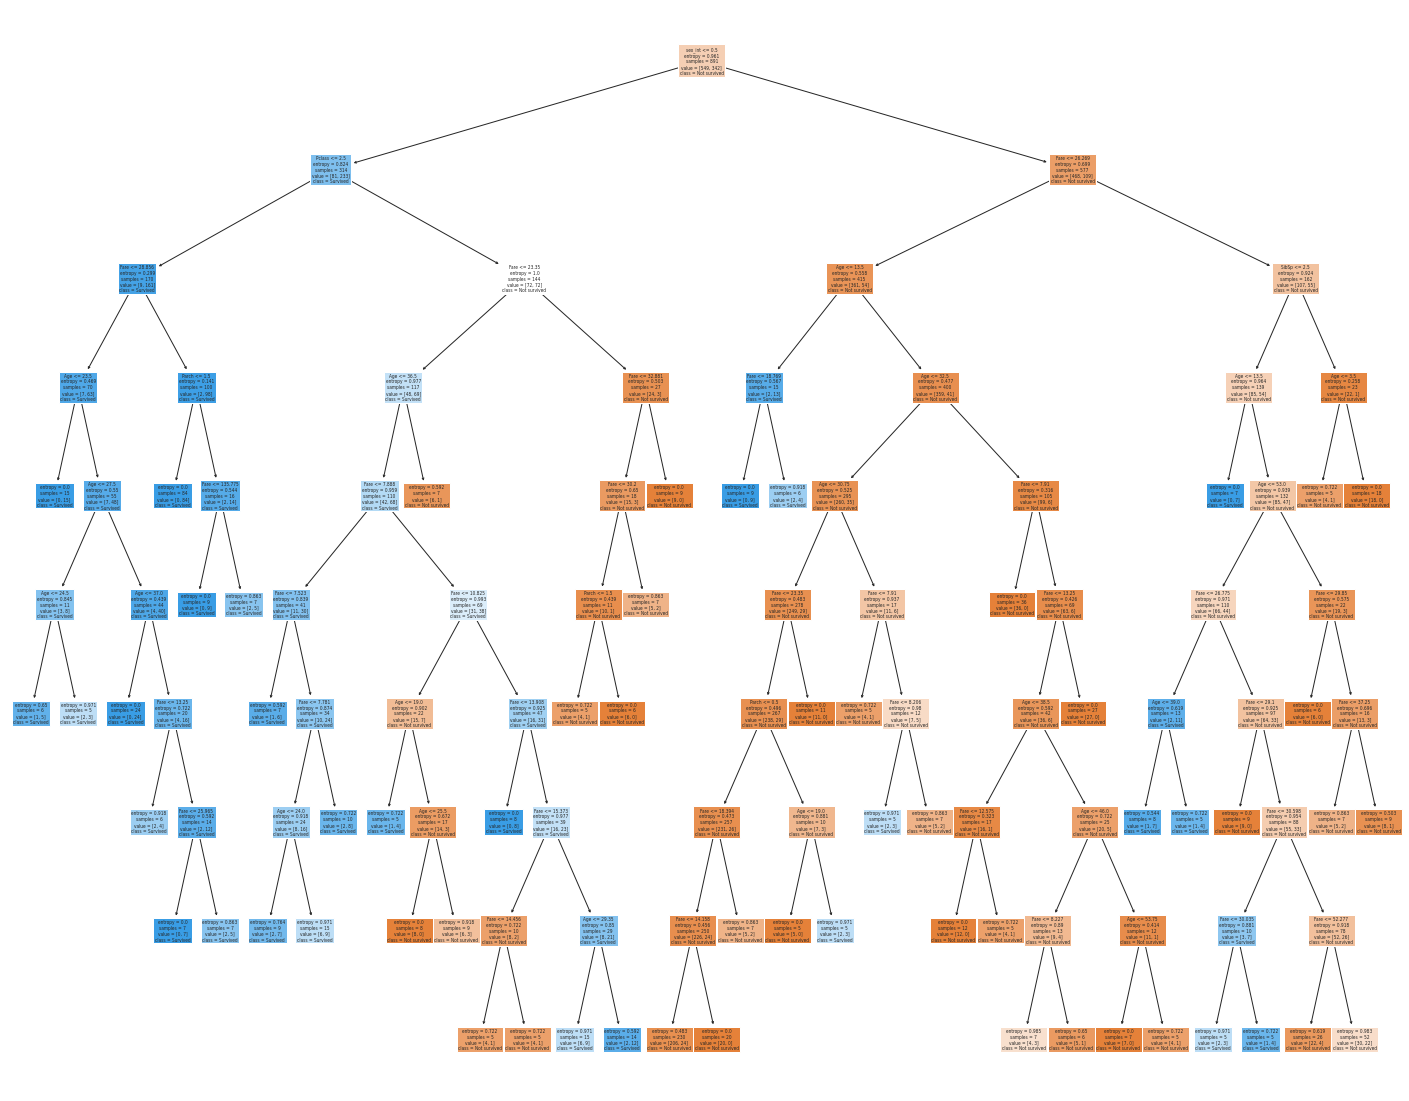

In [52]:
tree4 = DecisionTreeClassifier(
    criterion='entropy', 
    max_depth=9, 
    min_samples_leaf=5,
    min_samples_split=6,
    random_state=seed)

tree4.fit(X_train, Y_train)
y_pred = tree4.predict(X_test)
accuracy = round(tree4.score(X_train, Y_train) * 100, 2)
print(accuracy)

fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(tree4, 
                   feature_names=X_train.columns,  
                   class_names=train_df.survived_or_not,
                   filled=True)

submission = test_df[['PassengerId']].copy()
submission['Survived'] = Y_pred
submission.to_csv('submission4.csv', index=None)

# pontuação -> 0,77033
# posição -> 8641

In [53]:
submission = test_df[['PassengerId']].copy()
submission['Survived'] = Y_pred
submission.to_csv('submission.csv', index=None)